# Estimación de la temperatura de transición de fase en un modelo de Ising 2D usando deep learning.

# Dependencias

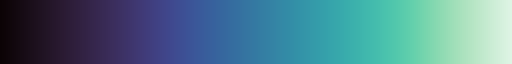

In [1]:
import numpy as np
import pandas as pd

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

import seaborn as sns
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

#import torcheval.metrics.functional as metrics
from torcheval.metrics import MulticlassConfusionMatrix

from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc

import os
import glob
import re
from pathlib import Path

np.random.seed(42)
sns.set_style("darkgrid")
sns.color_palette("mako", as_cmap=True)

# Formateo de datos
![Figura1](https://imgur.com/ITmxFFF.png)

In [2]:
#T = np.array([.1 , .5 , 1. , 1.5 , 2.5 , 3. , 3.5 , 4.])
T = np.array([0.1, 0.305263, 0.510526, 0.715789, 0.921053, 1.12632, 1.33158, 1.53684,
                                        1.74211, 1.94737, 2.15263, 2.35789, 2.56316, 2.76842, 2.97368, 3.17895,
                                        3.38421, 3.58947, 3.79474, 4.0])
Paths = ["../Dataset" + f"{t:.6f}" + ".txt" for t in T]
DataFrames = [pd.read_fwf(path , header = None) for path in Paths]


In [3]:
def Create_DataFrame(df_list):
    df =  pd.concat(df_list)
    return df
    # Queda pensar si remover duplicados
    
Data_set = Create_DataFrame(DataFrames)
Data_set

,0,1,2,3,4,5,6,7,8,9,...,91,92,93,94,95,96,97,98,99,100
0,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,0
1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,0
2,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,0
3,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,0
4,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,1,1,1,1,1,1,1,1,1,1,...,-1,1,1,1,1,1,1,-1,1,1
4996,-1,-1,-1,-1,-1,-1,-1,-1,1,1,...,1,-1,-1,-1,-1,-1,1,1,1,1
4997,-1,1,1,1,-1,-1,-1,1,1,-1,...,-1,-1,-1,-1,-1,-1,-1,1,-1,1
4998,1,1,1,-1,1,1,1,-1,-1,-1,...,-1,1,1,1,-1,1,1,-1,1,1


# Implementacion NN

## Clase DataSet

In [4]:
class Data(Dataset):
  def __init__(self , Predictors , Targets):
    self.x = Predictors
    self.y = Targets
    self.len = len(Predictors)
    
  def __getitem__(self, index):
    #print (len(self.x),len(self.y))
    return self.x[index], self.y[index]

  def __len__(self):
    return self.len

## Arquitectura NN


In [5]:
class NN(nn.Module):
  def __init__(self , Layers):
    super(NN , self).__init__()
    self.__Layers__ = nn.ModuleList()
    self.__BatchNorm__ = nn.ModuleList()

    for i in range(len(Layers) - 1) :
      Layer = nn.Linear(in_features = Layers[i] , out_features = Layers[i+1])
      torch.nn.init.kaiming_uniform_(Layer.weight , nonlinearity = "relu")
      self.__Layers__.append(Layer)

      BN = nn.BatchNorm1d(num_features = Layers[i+1] )
      self.__BatchNorm__.append(BN)

    self.state_dict = self.__Layers__.state_dict

#-------------------------------------------------------------------------------
  def forward(self , X):
    L = len(self.__Layers__)

    for l,Layer in enumerate(self.__Layers__):
      if l < L-1:
        X = F.relu(self.__BatchNorm__[l](Layer(X)))
      else:
        X =  Layer(X)
    return X

## Loop de entrenamiento


In [6]:
def Train(Model, Data_Train_Loader, Data_Val_Loader, Criterion, Optimizer, Epochs):
    Results = {
        "Training_Loss": [], "Training_Accuracy": [],
        "Validation_Loss": [], "Validation_Accuracy": [],
        "Validation_Precision": [], "Validation_Recall": [], "Validation_F1": []
    }

    for epoch in range(Epochs):
        # ENTRENAMIENTO
        Model.train()
        train_loss = 0.0
        all_train_preds, all_train_labels = [], []

        for X, Y in Data_Train_Loader:
            Optimizer.zero_grad()
            Y_hat = Model(X)
            loss = Criterion(Y_hat, Y)
            loss.backward()
            Optimizer.step()


            train_loss += loss.item() * X.size(0) # Multiplicar por el tamaño del batch
            preds = torch.argmax(Y_hat, dim=1)
            all_train_preds.extend(preds.detach().cpu().numpy())
            all_train_labels.extend(Y.detach().cpu().numpy())

        # Perdida promedio por muestra (no por batch)
        avg_train_loss = train_loss / len(Data_Train_Loader.dataset)
        train_acc = accuracy_score(all_train_labels, all_train_preds)

        # VALIDACION
        Model.eval()
        val_loss = 0.0
        all_val_preds, all_val_labels = [], []
        with torch.no_grad():
            for X, Y in Data_Val_Loader:
                Y_hat = Model(X)
                loss = Criterion(Y_hat, Y)

                val_loss += loss.item() * X.size(0)  # MultiplicaR por el tamaño del batch

                preds = torch.argmax(Y_hat, dim=1)
                all_val_preds.extend(preds.detach().cpu().numpy())
                all_val_labels.extend(Y.detach().cpu().numpy())

        # Perdida promedio por muestra en validación
        avg_val_loss = val_loss / len(Data_Val_Loader.dataset)
        val_acc = accuracy_score(all_val_labels, all_val_preds)
        val_prec = precision_score(all_val_labels, all_val_preds, average="macro", zero_division=0)
        val_rec = recall_score(all_val_labels, all_val_preds, average="macro", zero_division=0)
        val_f1 = f1_score(all_val_labels, all_val_preds, average="macro", zero_division=0)

        # Guardar resultados
        Results["Training_Loss"].append(avg_train_loss)
        Results["Training_Accuracy"].append(train_acc)
        Results["Validation_Loss"].append(avg_val_loss)
        Results["Validation_Accuracy"].append(val_acc)
        Results["Validation_Precision"].append(val_prec)
        Results["Validation_Recall"].append(val_rec)
        Results["Validation_F1"].append(val_f1)

        # Imprimir cada x epocas
        if epoch % 2 == 0 or epoch == Epochs - 1:
            print(f"Epoch {epoch+1}/{Epochs}: "
                  f"Train Loss: {avg_train_loss:.4f}, Train Acc: {train_acc:.4f}, "
                  f"Val Loss: {avg_val_loss:.4f}, Val Acc: {val_acc:.4f}")

    return Results

## Entrenamiento


### Preparacion de los datos

In [7]:
# Train - Test split
x = Data_set.iloc[:,:-1]
y = Data_set.iloc[:,-1]

X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.25, random_state=42, stratify=y, shuffle=True)

#-------------------------------------------------------------------------------
X_train = torch.tensor(X_train.values , dtype=torch.float32) 
X_test = torch.tensor(X_test.values , dtype=torch.float32)
y_train = torch.tensor(y_train.values , dtype=torch.long)
y_test = torch.tensor(y_test.values, dtype=torch.long)

#-------------------------------------------------------------------------------
Data_Train = Data(Predictors = X_train , Targets =  y_train)
Data_Test = Data(Predictors = X_test , Targets =  y_test)

#------------------------------------------------------------------------------
batch_size_train = X_train.shape[0]
batch_size_test = X_test.shape[0]

print(f"batch_size_train = {batch_size_train} \n batch_size_test = {batch_size_test}")

Train_Loader = DataLoader(Data_Train , batch_size = batch_size_train , shuffle = False )
Test_Loader = DataLoader(Data_Test , batch_size = batch_size_test , shuffle = False)

batch_size_train = 75000 
 batch_size_test = 25000


### Configuracion del modelo

In [8]:
# Hiperparametros
lr = 0.0001
weight_decay = 1e-4
Epochs = 100

# Arquitectura
l0 = X_train.shape[1]
l1 = int(.8 * l0)
l2 = int(.6 * l0)
l3 = int(.5 * l0)

Layers = [l0,l1,l2,l3,2]
print(f"El modelo tiene las siguientes capas: {Layers}")
Model_Balanced = NN(Layers)

# Costo y optimizacion
Criterion = nn.CrossEntropyLoss()
Optimizer =  torch.optim.Adam(Model_Balanced.parameters(), lr=lr , weight_decay=weight_decay)

El modelo tiene las siguientes capas: [100, 80, 60, 50, 2]


In [9]:
# TRAINING CELL
Results = Train(Model = Model_Balanced , Data_Train_Loader = Train_Loader , Data_Val_Loader = Test_Loader ,
                Criterion  = Criterion , Optimizer = Optimizer , Epochs =  Epochs)

Epoch 1/100: Train Loss: 0.8723, Train Acc: 0.6460, Val Loss: 0.6715, Val Acc: 0.7355
Epoch 3/100: Train Loss: 0.8251, Train Acc: 0.6566, Val Loss: 0.6757, Val Acc: 0.7127
Epoch 5/100: Train Loss: 0.7807, Train Acc: 0.6672, Val Loss: 0.6775, Val Acc: 0.6997
Epoch 7/100: Train Loss: 0.7382, Train Acc: 0.6776, Val Loss: 0.6719, Val Acc: 0.6904
Epoch 9/100: Train Loss: 0.6980, Train Acc: 0.6891, Val Loss: 0.6658, Val Acc: 0.6886
Epoch 11/100: Train Loss: 0.6616, Train Acc: 0.7002, Val Loss: 0.6538, Val Acc: 0.6906
Epoch 13/100: Train Loss: 0.6289, Train Acc: 0.7114, Val Loss: 0.6365, Val Acc: 0.6956
Epoch 15/100: Train Loss: 0.5989, Train Acc: 0.7219, Val Loss: 0.6165, Val Acc: 0.7024
Epoch 17/100: Train Loss: 0.5721, Train Acc: 0.7326, Val Loss: 0.5952, Val Acc: 0.7107
Epoch 19/100: Train Loss: 0.5488, Train Acc: 0.7413, Val Loss: 0.5728, Val Acc: 0.7188
Epoch 21/100: Train Loss: 0.5270, Train Acc: 0.7494, Val Loss: 0.5515, Val Acc: 0.7282
Epoch 23/100: Train Loss: 0.5068, Train Acc: 0.7

[Text(0.5, 1.0, 'Accuracy'), Text(0.5, 0, 'Epochs')]

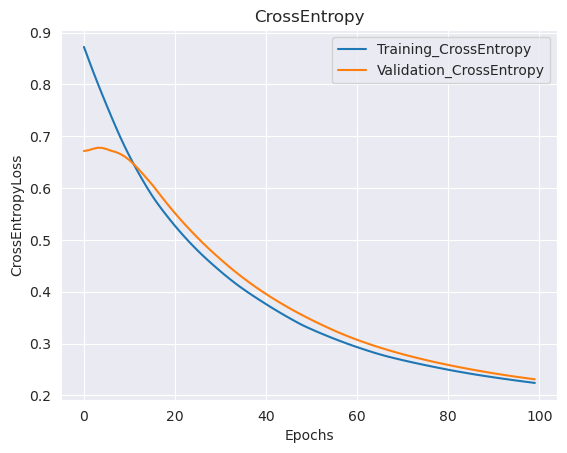

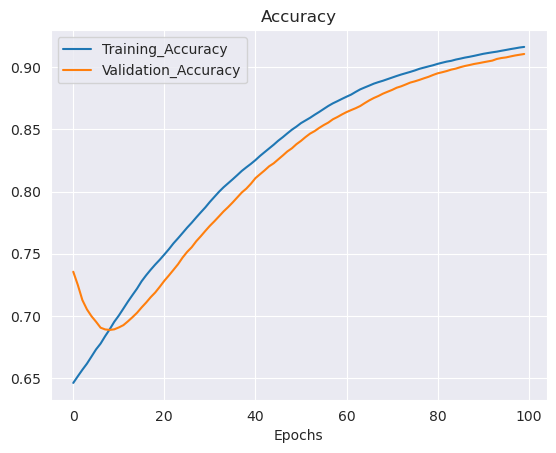

In [10]:
# Graficas
fig1 , ax1 = plt.subplots()
sns.lineplot(x = range(Epochs) , y = Results["Training_Loss"] , label = "Training_CrossEntropy" , ax = ax1)
sns.lineplot(x = range(Epochs) , y = Results["Validation_Loss"] , label = "Validation_CrossEntropy"  ,ax = ax1).set(title = "CrossEntropy",
                                                                                                          xlabel = "Epochs",
                                                                                                          ylabel = "CrossEntropyLoss")


fig2 , ax2 = plt.subplots()
sns.lineplot(x = range(Epochs) , y = Results["Training_Accuracy"] , label = "Training_Accuracy" , ax = ax2)
sns.lineplot(x = range(Epochs) , y = Results["Validation_Accuracy"] , label = "Validation_Accuracy"  ,ax = ax2).set(title="Accuracy",
                                                                                                       xlabel = "Epochs")

[Text(0.5, 1.0, 'Score-Macro Averaged'), Text(0.5, 0, 'Epochs')]

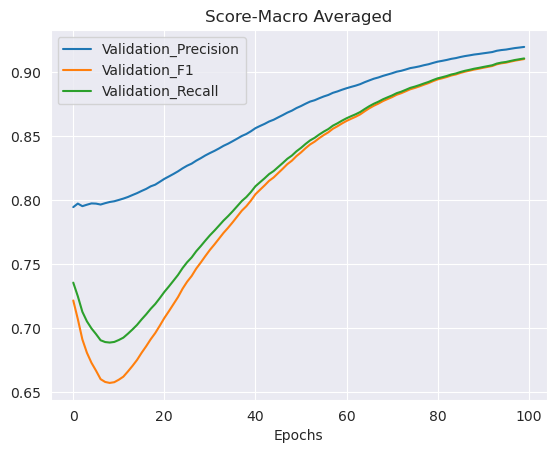

In [11]:
fig3 , ax3 = plt.subplots()
sns.lineplot(x = range(Epochs) , y = Results["Validation_Precision"] , label = "Validation_Precision" , ax = ax3)
sns.lineplot(x = range(Epochs) , y = Results["Validation_F1"] , label = "Validation_F1" , ax = ax3)
sns.lineplot(x = range(Epochs) , y = Results["Validation_Recall"] , label = "Validation_Recall"  ,ax = ax3).set(title="Score-Macro Averaged",
                                                                                                       xlabel = "Epochs")

/tmp/ipykernel_44204/1234306706.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_input = torch.tensor(X_test, dtype=torch.float32)


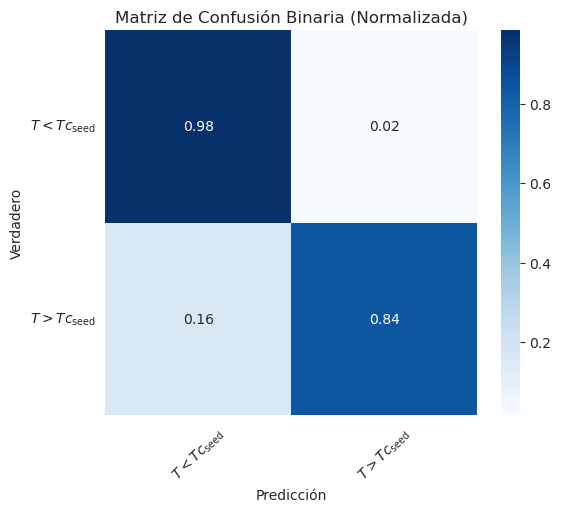

In [ ]:
if y_test.dtype != torch.long:
    y_test = y_test.long()

positive_class = 1  
y_test_bin = (y_test == positive_class).long() 

metric = MulticlassConfusionMatrix(num_classes=2, normalize='true')

# Pasar los datos por el modelo
with torch.no_grad():
    X_input = torch.tensor(X_test, dtype=torch.float32)
    logits = Model_Balanced(X_input)
    preds_multiclass = torch.argmax(logits, dim=1)
    preds_bin = (preds_multiclass == positive_class).long()  # Convertir predicciones a binario

    metric.update(input=preds_bin, target=y_test_bin)

# Visualizar la matriz de confusion
conf_matrix = metric.compute().cpu().numpy()
class_names = [r'$T < Tc_{\text{seed}}$', r'$T > Tc_{\text{seed}}$']  # Etiquetas binarias

plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, cmap='Blues', annot=True, fmt=".2f",
            xticklabels=class_names, yticklabels=class_names)
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.title('Matriz de Confusión Binaria (Normalizada)')
plt.xlabel('Predicción')
plt.ylabel('Verdadero')
plt.show()


# Estimacion de la temperatura critica
Ahora utilizamos nuestro modelo entrenado en los distintos datasets generados a diferentes temperaturas para ver qué tan bien funciona en dichos datos. Naturalmente, a medida que se evalúa el modelo en temperaturas cercanas a la temperatura crítica real, este no será capaz de distinguir entre un microestado ordenado y uno desordenado. Se espera, entonces, que la métrica accuracy en regiones de temperatura cercanas a la temperatura crítica real caiga abruptamente. ¡Es en este punto donde estimamos la temperatura crítica real del sistema!

In [ ]:
def Validate_t(Model, Data_Val_Loader):
    Results = {
        "Training_Loss": [], "Training_Accuracy": [],
        "Validation_Loss": [], "Validation_Accuracy": [],
        "Validation_Precision": [], "Validation_Recall": [], "Validation_F1": []}
    Model.eval()
    val_loss = 0.0
    all_val_preds, all_val_labels = [], []
    with torch.no_grad():
        for X, Y in Data_Val_Loader:
            Y_hat = Model(X)
            loss = Criterion(Y_hat, Y)

            val_loss += loss.item() * X.size(0)  # MultiplicaR por el tamaño del batch

            preds = torch.argmax(Y_hat, dim=1)
            all_val_preds.extend(preds.detach().cpu().numpy())
            all_val_labels.extend(Y.detach().cpu().numpy())

        # Perdida promedio por muestra en validacion
        avg_val_loss = val_loss / len(Data_Val_Loader.dataset)
        val_acc = accuracy_score(all_val_labels, all_val_preds)
        val_prec = precision_score(all_val_labels, all_val_preds, average="macro", zero_division=0)
        val_rec = recall_score(all_val_labels, all_val_preds, average="macro", zero_division=0)
        val_f1 = f1_score(all_val_labels, all_val_preds, average="macro", zero_division=0)

        # Guardar resultados
        Results["Validation_Loss"].append(avg_val_loss)
        Results["Validation_Accuracy"].append(val_acc)
        Results["Validation_Precision"].append(val_prec)
        Results["Validation_Recall"].append(val_rec)
        Results["Validation_F1"].append(val_f1)


    return Results

In [14]:
Accuracies = []
for t,df in zip(T,DataFrames):
    x = df.iloc[:,:-1]
    y = df.iloc[:,-1]

    #-------------------------------------------------------------------------------
    X = torch.tensor(x.values , dtype=torch.float32) 
    y = torch.tensor(y.values, dtype=torch.long)

    #-------------------------------------------------------------------------------
    data = Data(Predictors = X , Targets =  y)
    
    #------------------------------------------------------------------------------
    batch_size = X.shape[0]
    print(f"batch_size = {batch_size}")

    Loader = DataLoader(data , batch_size = batch_size , shuffle = False )
    Results = Validate_t(Model_Balanced, Loader)
    Accuracies.append(Results["Validation_Accuracy"])
    
Accuracies = np.array(Accuracies).reshape(-1,)

batch_size = 5000
batch_size = 5000
batch_size = 5000
batch_size = 5000
batch_size = 5000
batch_size = 5000
batch_size = 5000
batch_size = 5000
batch_size = 5000
batch_size = 5000
batch_size = 5000
batch_size = 5000
batch_size = 5000
batch_size = 5000
batch_size = 5000
batch_size = 5000
batch_size = 5000
batch_size = 5000
batch_size = 5000
batch_size = 5000


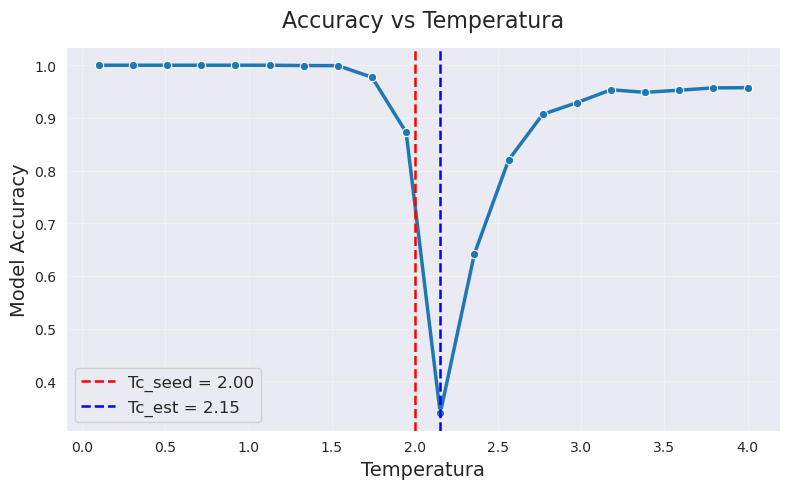

In [15]:
Tc_seed = 2.
idx_min = np.argmin(Accuracies)
Tc_est = T[idx_min]

plt.figure(figsize=(8,5))
sns.lineplot(x=T, y=Accuracies, marker="o", linewidth=2.5)

plt.axvline(x=Tc_seed, color="red", linestyle="--", linewidth=1.8, label=f"Tc_seed = {Tc_seed:.2f}")
plt.axvline(x=Tc_est, color="blue", linestyle="--", linewidth=1.8, label=f"Tc_est = {Tc_est:.2f}")

plt.xlabel("Temperatura", fontsize=14)
plt.ylabel("Model Accuracy", fontsize=14)
plt.title("Accuracy vs Temperatura", fontsize=16, pad=15)

plt.legend(fontsize=12, loc="best")
sns.despine()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()